In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(-math.pi,math.pi)
#p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

Text(0, 0.5, 'Encoding')

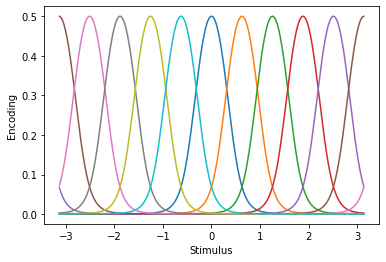

In [4]:
#CIRCULAR ENCODER/DECODER TRY
enc_circ = CircularBernoulliEncoder(N)
dec = MLPDecoder(N,200)
r = enc_circ.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")


#TO DO: circular decoder with von mises circular distribution + circular rate

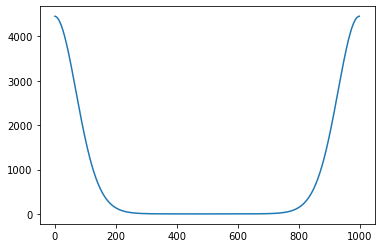

In [5]:
r = enc_circ.sample(x_fine,10)
a = 30
theta = torch.as_tensor(math.pi)
k = 5
func = a*torch.exp(k*torch.cos(x_fine - theta))
plt.plot(func)



In [6]:
class ModifiedBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp, nu):
        ctx._nu = nu
        ctx.save_for_backward(inp)
        return torch.from_numpy(scipy.special.iv(nu, inp.detach().numpy()))
    @staticmethod
    def backward(ctx, grad_out):
        inp, = ctx.saved_tensors
        nu = ctx._nu
        
        return 0.5* grad_out *(ModifiedBessel.apply(inp, nu - 1.0)+ModifiedBessel.apply(inp, nu + 1.0)), None




modified_bessel = ModifiedBessel.apply



In [10]:
x = torch.randn(5, requires_grad=True, dtype=torch.float64)
torch.autograd.gradcheck(lambda x: modified_bessel(x, 0.0), (x,))




l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,10,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.5)
mu_dec,sigma2_dec = dec(r)
k = (1/sigma2_dec)

modified_bessel(k,0)



tensor([[1.1683, 1.1502, 1.1448,  ..., 1.1467, 1.1800, 1.1793],
        [1.1790, 1.1466, 1.1628,  ..., 1.1470, 1.1965, 1.1732],
        [1.1475, 1.1804, 1.1330,  ..., 1.1518, 1.1454, 1.1786],
        ...,
        [1.1776, 1.1633, 1.1779,  ..., 1.1715, 1.1318, 1.1504],
        [1.1461, 1.1436, 1.1309,  ..., 1.1803, 1.1799, 1.1792],
        [1.1692, 1.1265, 1.1579,  ..., 1.1709, 1.1467, 1.1728]],
       grad_fn=<ModifiedBesselBackward>)

In [ ]:
class ModifiedBessel_nn(torch.nn.Module):
 
    def __init__(self,nu0, k0):
        super().__init__()
        self.nu = torch.nn.Parameter(nu0)
        self.k = torch.nn.Parameter(k0)
        
    def forward(self,nu,k):
        self.nu = nu
        return torch.from_numpy(scipy.special.iv(nu, k.detach().numpy()))
    def backward(self,grad_):
        

In [7]:
def distortion_circular(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    #ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,sigma2_dec = decoder(r)
    k = (1/sigma2_dec).detach()
    #mp = mu_dec*k
    logq_x_r = k*torch.cos(x-mu_dec) - modified_bessel(k,0) # -  torch.log(torch.i0(k)) # torch.log(2*torch.as_tensor(math.pi))
    D = -logq_x_r.mean()
    return D

#scipy.special.iv(0,k) = modified Bessel function of the first kind of order 0



In [12]:
enc_circ = CircularBernoulliEncoder(N)
l_r_x = enc_circ(x_fine)
dec = MLPDecoder(N,200)
params = enc_circ.parameters()
opt = torch.optim.Adam(params,lr)

loss = distortion_circular(x_fine,enc_circ,dec)
opt.zero_grad()
loss.backward()
opt.step()

In [11]:
for e in range(100):
    loss = distortion_circular(x_fine,enc_circ,dec)
    #print(modified_bessel(k,0))
    print(loss)
    print(loss.grad)
    opt.zero_grad()
    loss.backward()
    opt.step()

tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)

<ipython-input-11-640d464418d9>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(loss.grad)



None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)
None
tensor(nan, grad_fn=<NegBackward>)

In [9]:
 distortion_circular(x_fine,enc_circ,dec)

tensor(-0.5904, grad_fn=<NegBackward>)

In [10]:
l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,10,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.5)
mu_dec,sigma2_dec = dec(r)
k = (1/sigma2_dec).detach()
mp = mu_dec*k
logq_x_r = k*torch.cos(x_fine-mu_dec) - torch.log(2*torch.as_tensor(math.pi))  - torch.log(scipy.special.kn(0,k))
#D = -logq_x_r.mean()
#D

#mu_dec




In [8]:
q = rate_ising(N)
loss = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)

In [9]:
ciao = scipy.special.kn(0,5)
#r = enc_circ.sample(x_fine,10)

#Traning on the entire set of parameters
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc_circ.parameters(),dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        #rate = q(enc_circ,x_)
        dist = distortion_circular(x_,enc_circ,dec)
        loss = dist
        print(dist)
    
        opt.zero_grad()
        loss.backward()
        
        opt.step()
        lossVec.append(loss.item())
        #rateVec.append(rate.item())
        #distVec.append(dist.item())

In [9]:
#params = itertools.chain(enc_circ.parameters(),dec.parameters())
params = dec.parameters() #+ list(enc_circ.parameters()) +
lr = 1e-3
opt = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    dist = distortion_circular(x_fine,enc_circ,dec)
    loss = dist
    print(dist)
    #print(params.grad)
    
    opt.zero_grad()
    #loss.retain_grad()
    loss.backward()
        
    opt.step()
    #print(loss.grad)
    

tensor(1.1860, grad_fn=<NegBackward>)
tensor(1.1828, grad_fn=<NegBackward>)
tensor(1.1817, grad_fn=<NegBackward>)
tensor(1.1785, grad_fn=<NegBackward>)
tensor(1.1777, grad_fn=<NegBackward>)
tensor(1.1742, grad_fn=<NegBackward>)
tensor(1.1731, grad_fn=<NegBackward>)
tensor(1.1698, grad_fn=<NegBackward>)
tensor(1.1686, grad_fn=<NegBackward>)
tensor(1.1654, grad_fn=<NegBackward>)
tensor(1.1628, grad_fn=<NegBackward>)
tensor(1.1598, grad_fn=<NegBackward>)
tensor(1.1587, grad_fn=<NegBackward>)
tensor(1.1569, grad_fn=<NegBackward>)
tensor(1.1542, grad_fn=<NegBackward>)
tensor(1.1508, grad_fn=<NegBackward>)
tensor(1.1484, grad_fn=<NegBackward>)
tensor(1.1469, grad_fn=<NegBackward>)
tensor(1.1447, grad_fn=<NegBackward>)
tensor(1.1420, grad_fn=<NegBackward>)
tensor(1.1374, grad_fn=<NegBackward>)
tensor(1.1353, grad_fn=<NegBackward>)
tensor(1.1341, grad_fn=<NegBackward>)
tensor(1.1287, grad_fn=<NegBackward>)
tensor(1.1259, grad_fn=<NegBackward>)
tensor(1.1225, grad_fn=<NegBackward>)
tensor(1.118

Text(0, 0.5, 'Encoding')

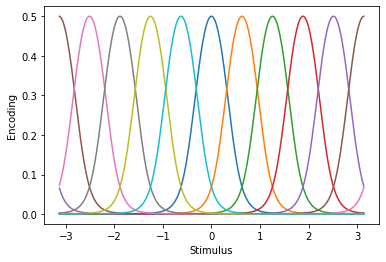

In [10]:
plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [ ]:
r = enc_circ.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()

ValueError: The parameter logits has invalid values

In [102]:
a = torch.ones(10)
a.requires_grad = True
loss = scipy.special.kn(0,a.mean())

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [101]:
a

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)